<a href="https://colab.research.google.com/github/Luka-Surmanidze/MLHW4/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/yEXkEUqK52Q

**Downloading Kaggle data sets directly into Colab**

Install the kaggle python library

In [2]:
! pip install kaggle

Mount the Google drive so you can store your kaggle API credentials for future use

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a directory for kaggle at the temporary instance location on Colab drive.

Download your kaggle API key (.json file). You can do this by going to your kaggle account page and clicking 'Create new API token' under the API section.

In [4]:
! mkdir ~/.kaggle

If you want to copy the kaggle API credentials to the temporary location... (I recommend placing it on your Google Drive)

In [5]:
! cp kaggle.json ~/.kaggle/

Upload the json file to Google Drive and then copy to the temporary location.

In [ ]:
# !cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

**1. Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [7]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 86% 246M/285M [00:00<00:00, 800MB/s] 
100% 285M/285M [00:00<00:00, 837MB/s]


Unzip, in case the downloaded file is zipped. Refresh the files on the left hand side to update the view.

In [8]:
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip


Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


To downloaad specific files, instead of the netire data set



In [ ]:
# ! kaggle competitions download house-prices-advanced-regression-techniques -f train.csv

train.csv: Skipping, found more recently modified local copy (use --force to force download)


**2. Download datasets (that are not part of competition)**

In [ ]:
# ! kaggle datasets download andrewmvd/animal-faces

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 688M/696M [00:11<00:00, 130MB/s]
100% 696M/696M [00:11<00:00, 61.0MB/s]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import wandb
from tqdm import tqdm
import os
from PIL import Image

# Initialize Wandb for Model 2
wandb.init(
    project="facial-expression-recognition",
    name="deeper-cnn-enhanced",
    config={
        "model_type": "Deeper CNN",
        "layers": 4,
        "epochs": 60,
        "batch_size": 32,
        "learning_rate": 0.0005,
        "optimizer": "Adam",
        "scheduler": "StepLR",
        "data_augmentation": True,
        "batch_normalization": True,
        "architecture": "4 Conv blocks + 3 FC layers + BN + Dropout"
    }
)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: surmanidzeluka (surmanidzeluka-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
class FERDatasetAugmented(Dataset):

    def __init__(self, csv_file, transform=None, is_training=True):
        self.data = pd.read_csv(csv_file)
        self.is_training = is_training

        if transform is None:
            if is_training:
                self.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(degrees=10),
                    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485], std=[0.229])  # ImageNet stats for grayscale
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485], std=[0.229])
                ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        pixels = np.array([int(pixel) for pixel in pixels.split()])
        image = pixels.reshape(48, 48).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image).float().unsqueeze(0) / 255.0

        return image, torch.tensor(emotion, dtype=torch.long)


In [11]:
class DeeperCNN(nn.Module):


    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(DeeperCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 48x48 -> 24x24

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 24x24 -> 12x12

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 12x12 -> 6x6

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)  # 6x6 -> 3x3

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_rate * 0.5)  # Less dropout in deeper layers

        self.fc3 = nn.Linear(128, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 3 * 3)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

In [12]:
def train_model_enhanced(model, train_loader, val_loader, num_epochs=60):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []

    best_val_acc = 0.0
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        learning_rates.append(current_lr)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'deeper_cnn_best_model.pth')
        else:
            patience_counter += 1

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'learning_rate': current_lr,
            'best_val_accuracy': best_val_acc
        })

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {current_lr:.6f}')
        print(f'Best Val Acc: {best_val_acc:.2f}%')
        print('-' * 60)

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [13]:
def evaluate_model_detailed(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)

    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    report = classification_report(all_labels, all_predictions,
                                 target_names=emotion_labels, output_dict=True)

    print("\nPer-class Results:")
    for i, emotion in enumerate(emotion_labels):
        if str(i) in report:
            precision = report[str(i)]['precision']
            recall = report[str(i)]['recall']
            f1 = report[str(i)]['f1-score']
            print(f"{emotion:>10}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix - Deeper CNN Model', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    wandb.log({"confusion_matrix_model2": wandb.Image(plt)})
    plt.show()

    for i, emotion in enumerate(emotion_labels):
        if str(i) in report:
            wandb.log({
                f"precision_{emotion.lower()}": report[str(i)]['precision'],
                f"recall_{emotion.lower()}": report[str(i)]['recall'],
                f"f1_{emotion.lower()}": report[str(i)]['f1-score']
            })

    return accuracy, report


In [14]:
def plot_enhanced_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    epochs = range(1, len(train_losses) + 1)

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    loss_diff = np.array(val_losses) - np.array(train_losses)
    ax3.plot(epochs, loss_diff, 'g-', linewidth=2)
    ax3.set_title('Validation - Training Loss (Overfitting Indicator)', fontsize=14)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss Difference')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    if len(val_accuracies) > 1:
        acc_improvement = np.diff(val_accuracies)
        ax4.plot(epochs[1:], acc_improvement, 'purple', linewidth=2)
        ax4.set_title('Validation Accuracy Improvement per Epoch', fontsize=14)
        ax4.set_xlabel('Epochs')
        ax4.set_ylabel('Accuracy Change (%)')
        ax4.grid(True, alpha=0.3)
        ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    plt.tight_layout()
    wandb.log({"training_history_model2": wandb.Image(plt)})
    plt.show()


In [15]:
def create_sample_data(num_samples=1000):
    """Create sample FER data for testing purposes"""
    np.random.seed(42)
    data = []

    for i in range(num_samples):
        pixels = np.random.randint(0, 256, 48*48)
        pixel_string = ' '.join(map(str, pixels))
        emotion = np.random.randint(0, 7)
        data.append({'emotion': emotion, 'pixels': pixel_string})

    df = pd.DataFrame(data)
    df.to_csv('sample_train.csv', index=False)
    print(f"Created sample dataset with {num_samples} samples")
    return df

Loading dataset for Model 2...
Found dataset: train.csv
Training samples: 22967
Validation samples: 5742
Model 2 architecture:
DeeperCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, 

Epoch 1/60 [Train]: 100%|██████████| 718/718 [00:33<00:00, 21.20it/s, Loss=1.3245]


Epoch [1/60]
Train Loss: 1.4813, Train Acc: 41.86%
Val Loss: 1.2885, Val Acc: 50.42%
Learning Rate: 0.000500
Best Val Acc: 50.42%
------------------------------------------------------------


Epoch 2/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.52it/s, Loss=1.0692]


Epoch [2/60]
Train Loss: 1.2251, Train Acc: 53.64%
Val Loss: 1.1990, Val Acc: 54.56%
Learning Rate: 0.000500
Best Val Acc: 54.56%
------------------------------------------------------------


Epoch 3/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 23.11it/s, Loss=1.2103]


Epoch [3/60]
Train Loss: 1.1068, Train Acc: 58.63%
Val Loss: 1.2445, Val Acc: 53.90%
Learning Rate: 0.000500
Best Val Acc: 54.56%
------------------------------------------------------------


Epoch 4/60 [Train]: 100%|██████████| 718/718 [00:34<00:00, 20.98it/s, Loss=1.1174]


Epoch [4/60]
Train Loss: 0.9945, Train Acc: 62.95%
Val Loss: 1.1556, Val Acc: 56.88%
Learning Rate: 0.000500
Best Val Acc: 56.88%
------------------------------------------------------------


Epoch 5/60 [Train]: 100%|██████████| 718/718 [00:30<00:00, 23.18it/s, Loss=0.9780]


Epoch [5/60]
Train Loss: 0.8985, Train Acc: 66.37%
Val Loss: 1.2221, Val Acc: 55.92%
Learning Rate: 0.000500
Best Val Acc: 56.88%
------------------------------------------------------------


Epoch 6/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 23.00it/s, Loss=0.6998]


Epoch [6/60]
Train Loss: 0.7727, Train Acc: 72.07%
Val Loss: 1.2735, Val Acc: 54.01%
Learning Rate: 0.000500
Best Val Acc: 56.88%
------------------------------------------------------------


Epoch 7/60 [Train]: 100%|██████████| 718/718 [00:30<00:00, 23.25it/s, Loss=0.9536]


Epoch [7/60]
Train Loss: 0.6796, Train Acc: 75.30%
Val Loss: 1.2935, Val Acc: 57.66%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 8/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.49it/s, Loss=0.5112]


Epoch [8/60]
Train Loss: 0.5834, Train Acc: 79.00%
Val Loss: 1.4055, Val Acc: 56.04%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 9/60 [Train]: 100%|██████████| 718/718 [00:30<00:00, 23.19it/s, Loss=0.4752]


Epoch [9/60]
Train Loss: 0.5008, Train Acc: 82.29%
Val Loss: 1.4240, Val Acc: 56.77%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 10/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.72it/s, Loss=0.8146]


Epoch [10/60]
Train Loss: 0.4502, Train Acc: 84.16%
Val Loss: 1.6214, Val Acc: 53.10%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 11/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.62it/s, Loss=0.2634]


Epoch [11/60]
Train Loss: 0.3938, Train Acc: 86.09%
Val Loss: 1.5048, Val Acc: 56.34%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 12/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.79it/s, Loss=0.5585]


Epoch [12/60]
Train Loss: 0.3634, Train Acc: 87.11%
Val Loss: 1.6241, Val Acc: 56.06%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 13/60 [Train]: 100%|██████████| 718/718 [00:33<00:00, 21.37it/s, Loss=0.1967]


Epoch [13/60]
Train Loss: 0.3292, Train Acc: 88.54%
Val Loss: 1.7074, Val Acc: 56.25%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 14/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.49it/s, Loss=0.4237]


Epoch [14/60]
Train Loss: 0.3070, Train Acc: 89.44%
Val Loss: 1.8302, Val Acc: 56.20%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 15/60 [Train]: 100%|██████████| 718/718 [00:32<00:00, 21.86it/s, Loss=0.1779]


Epoch [15/60]
Train Loss: 0.2939, Train Acc: 89.87%
Val Loss: 1.8153, Val Acc: 56.34%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 16/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.92it/s, Loss=0.2333]


Epoch [16/60]
Train Loss: 0.2705, Train Acc: 90.61%
Val Loss: 1.7879, Val Acc: 55.21%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 17/60 [Train]: 100%|██████████| 718/718 [00:33<00:00, 21.59it/s, Loss=0.2300]


Epoch [17/60]
Train Loss: 0.2647, Train Acc: 90.91%
Val Loss: 1.8273, Val Acc: 55.43%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 18/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 23.04it/s, Loss=0.3734]


Epoch [18/60]
Train Loss: 0.2474, Train Acc: 91.54%
Val Loss: 1.9092, Val Acc: 56.13%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 19/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.89it/s, Loss=0.4091]


Epoch [19/60]
Train Loss: 0.2463, Train Acc: 91.46%
Val Loss: 1.8843, Val Acc: 55.80%
Learning Rate: 0.000500
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 20/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 22.86it/s, Loss=0.1754]


Epoch [20/60]
Train Loss: 0.2312, Train Acc: 92.08%
Val Loss: 1.8729, Val Acc: 55.56%
Learning Rate: 0.000250
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 21/60 [Train]: 100%|██████████| 718/718 [00:31<00:00, 23.06it/s, Loss=0.1412]


Epoch [21/60]
Train Loss: 0.1183, Train Acc: 96.23%
Val Loss: 2.3197, Val Acc: 56.70%
Learning Rate: 0.000250
Best Val Acc: 57.66%
------------------------------------------------------------


Epoch 22/60 [Train]: 100%|██████████| 718/718 [00:32<00:00, 22.01it/s, Loss=0.5268]


Epoch [22/60]
Train Loss: 0.0859, Train Acc: 97.23%
Val Loss: 2.3945, Val Acc: 56.53%
Learning Rate: 0.000250
Best Val Acc: 57.66%
------------------------------------------------------------
Early stopping triggered after 22 epochs


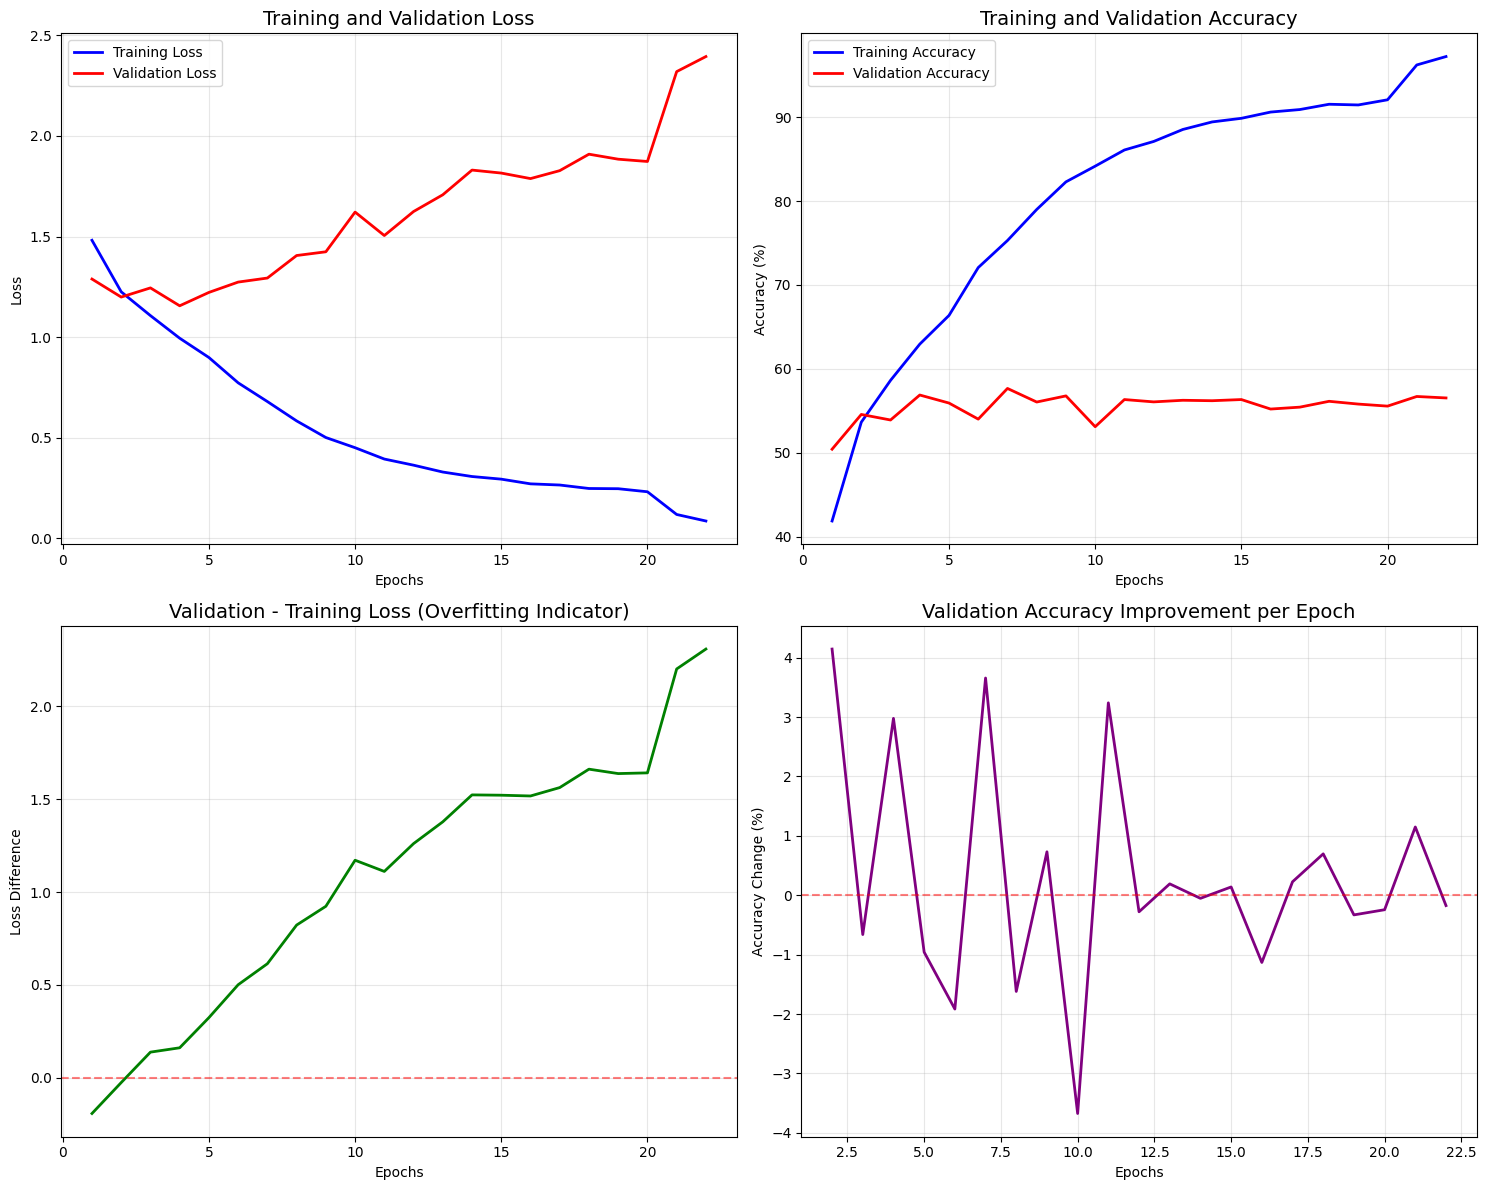


Evaluating Model 2...

Per-class Results:


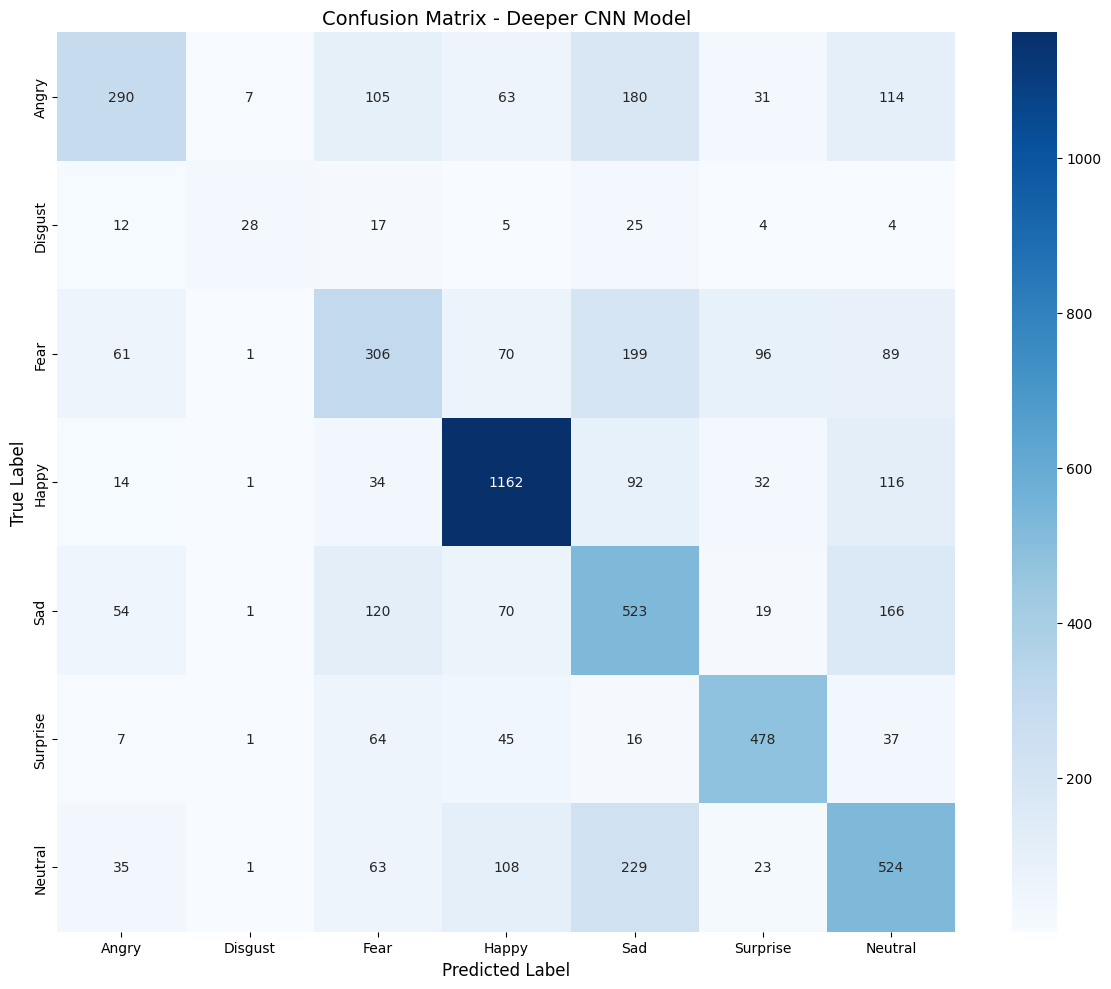

Final Validation Accuracy: 0.5766


Model 2 training completed and logged to Wandb!


In [16]:
if __name__ == "__main__":
    print("Loading dataset for Model 2...")

    possible_files = ['train.csv', 'fer2013.csv', 'sample_train.csv']
    dataset_file = None

    for file in possible_files:
        if os.path.exists(file):
            dataset_file = file
            print(f"Found dataset: {file}")
            break

    if dataset_file is None:
        print("No dataset found. Creating sample data...")
        create_sample_data(8000)  # Larger sample for Model 2
        dataset_file = 'sample_train.csv'

    full_dataset = FERDatasetAugmented(dataset_file, is_training=True)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    val_dataset.dataset.is_training = False
    val_dataset.dataset.transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    model = DeeperCNN(num_classes=7, dropout_rate=0.5)
    print(f"Model 2 architecture:\n{model}")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    wandb.config.update({
        "total_parameters": total_params,
        "trainable_parameters": trainable_params
    })

    print("\nStarting training of Model 2 (Deeper CNN)...")
    trained_model, train_losses, val_losses, train_accs, val_accs = train_model_enhanced(
        model, train_loader, val_loader, num_epochs=60
    )

    plot_enhanced_training_history(train_losses, val_losses, train_accs, val_accs)

    trained_model.load_state_dict(torch.load('deeper_cnn_best_model.pth'))

    print("\nEvaluating Model 2...")
    val_accuracy, report = evaluate_model_detailed(trained_model, val_loader)
    print(f"Final Validation Accuracy: {val_accuracy:.4f}")

    wandb.log({
        "final_val_accuracy_model2": val_accuracy,
        "final_train_accuracy_model2": max(train_accs),
        "parameter_count": total_params
    })

    wandb.finish()
    print("Model 2 training completed and logged to Wandb!")